In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.feature_extractors.SummaryStats2D import DY
from cell_inference.utils.data_manager import NpzFilesCollector

%matplotlib inline

TRIAL_NAME = 'Reduced_Order_stochastic_spkwid_trunkLR4_LactvCa_Loc3_h1_sumstats7'

## Load simulation data

In [2]:
DATA_PATH = paths.SIMULATED_DATA_PATH
TRIAL_PATH = os.path.join(DATA_PATH, TRIAL_NAME)

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

try:
    STATS = np.load(STATS_PATH)
except:
    STATS = NpzFilesCollector(STATS_PATH)
with STATS:
    full_summ_stats = STATS['x']
    labels = STATS['y']
    ys = STATS['ys']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'l_t', 'lr_pt', 'r_t', 'rr_dt']


In [3]:
# # Select summary statistics
# filter_id = [slice(8, 24), slice(56, 68), slice(72, 84)] # tr/pk time stats, decay and propagation fit
# tr_pk_time_ids = np.array([11, 12, 14, 15, 19, 20, 22, 23]) # tr/pk time stats
# filter_id[0] = tr_pk_time_ids
# feat_ids = np.arange(summ_stats.shape[1])
# feat_ids = np.concatenate([feat_ids[idx] for idx in filter_id])
# np.savetxt(os.path.join(TRIAL_PATH, 'TrPkStats_id.txt'), feat_ids, fmt='%d')

In [4]:
# load summary statistics
feat_ids = np.loadtxt(os.path.join(TRIAL_PATH, 'TrPkStats_id.txt'), dtype=int)

In [5]:
summ_stats = full_summ_stats[:, feat_ids]
summ_stats_names = params.SUMM_STATS_NAMES[feat_ids]
df_summ_stats = pd.DataFrame(dict(zip(summ_stats_names, summ_stats.T)))

### Transform labels

In [6]:
label_list = inference_list.copy()

In [7]:
has_yshift = 'y' in label_list and ys.size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = ys
    label_list[ys_idx] = 'ys'

df_la = pd.DataFrame(labels, columns=label_list)

with pd.option_context('display.max_rows', 10):
    display(df_la)

ys           d     theta          l_t     lr_pt       r_t  \
0    -14.414987  145.544253 -0.874783  1133.789502  0.145403  1.025618   
1    -24.528710   90.468007 -0.299473  1133.789502  0.145403  1.025618   
2     -1.375555   56.146029 -0.066361  1133.789502  0.145403  1.025618   
3     -1.890745   52.479145  0.529333  1133.789502  0.145403  1.025618   
4    -60.301096  171.990536  0.056110  1133.789502  0.145403  1.025618   
...         ...         ...       ...          ...       ...       ...   
5970  40.103103  136.813775  0.167987   281.350089  0.192341  0.523043   
5971  28.160091   79.585242  0.053111   281.350089  0.192341  0.523043   
5972  22.496673  171.220513 -0.221916   281.350089  0.192341  0.523043   
5973  18.885460  123.326905 -0.040408   281.350089  0.192341  0.523043   
5974  24.318666  198.304300  0.102905   281.350089  0.192341  0.523043   

         rr_dt  
0     0.707673  
1     0.707673  
2     0.707673  
3     0.707673  
4     0.707673  
...        ...  
5970  0.581720  
5971  0.581720  
5972  0.581720  
5973  0.581720  
5974  0.581720  

[5975 rows x 7 columns]

## Evaluate correlations

In [8]:
def corr_in_plot(x, y, xy=(.7, .9), ax=None, hue=None, **kwargs):
    """Plot the correlation coefficient at xy location of axis, by default top right"""
    corr = sp.stats.pearsonr(x, y)
    corr = corr.statistic if hasattr(corr, 'statistic') else corr[0]
    ax = ax or plt.gca()
    ax.annotate(f'p={corr:.3f}', xy=xy, xycoords=ax.transAxes)
    return corr

def aling_axes_limits(axes, axis='xy', include_diag=False):
    """Ensure limits of axes on each pairplot match"""
    lims = np.empty((2, axes.size, 2)) # (xy, axes, limits)
    for i, ax in enumerate(axes.ravel()):
        lims[0, i] = ax.get_xlim()
        lims[1, i] = ax.get_ylim()
    lims = lims.reshape((2, ) + axes.shape + (2, ))
    if not include_diag:
        for i in range(min(axes.shape)):
            lims[:, i, i, 0] = -np.inf
            lims[:, i, i, 1] = np.inf
    align_x, align_y = 'x' in axis, 'y' in axis
    xlims = np.column_stack((lims[0, :, :, 0].max(axis=0), lims[0, :, :, 1].min(axis=0))) if align_x else None
    ylims = np.column_stack((lims[1, :, :, 0].max(axis=1), lims[1, :, :, 1].min(axis=1))) if align_y else None
    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i, j]
            if align_x:
                ax.set_xlim(xlims[j])
            if align_y and (include_diag or i != j):
                ax.set_ylim(ylims[i])

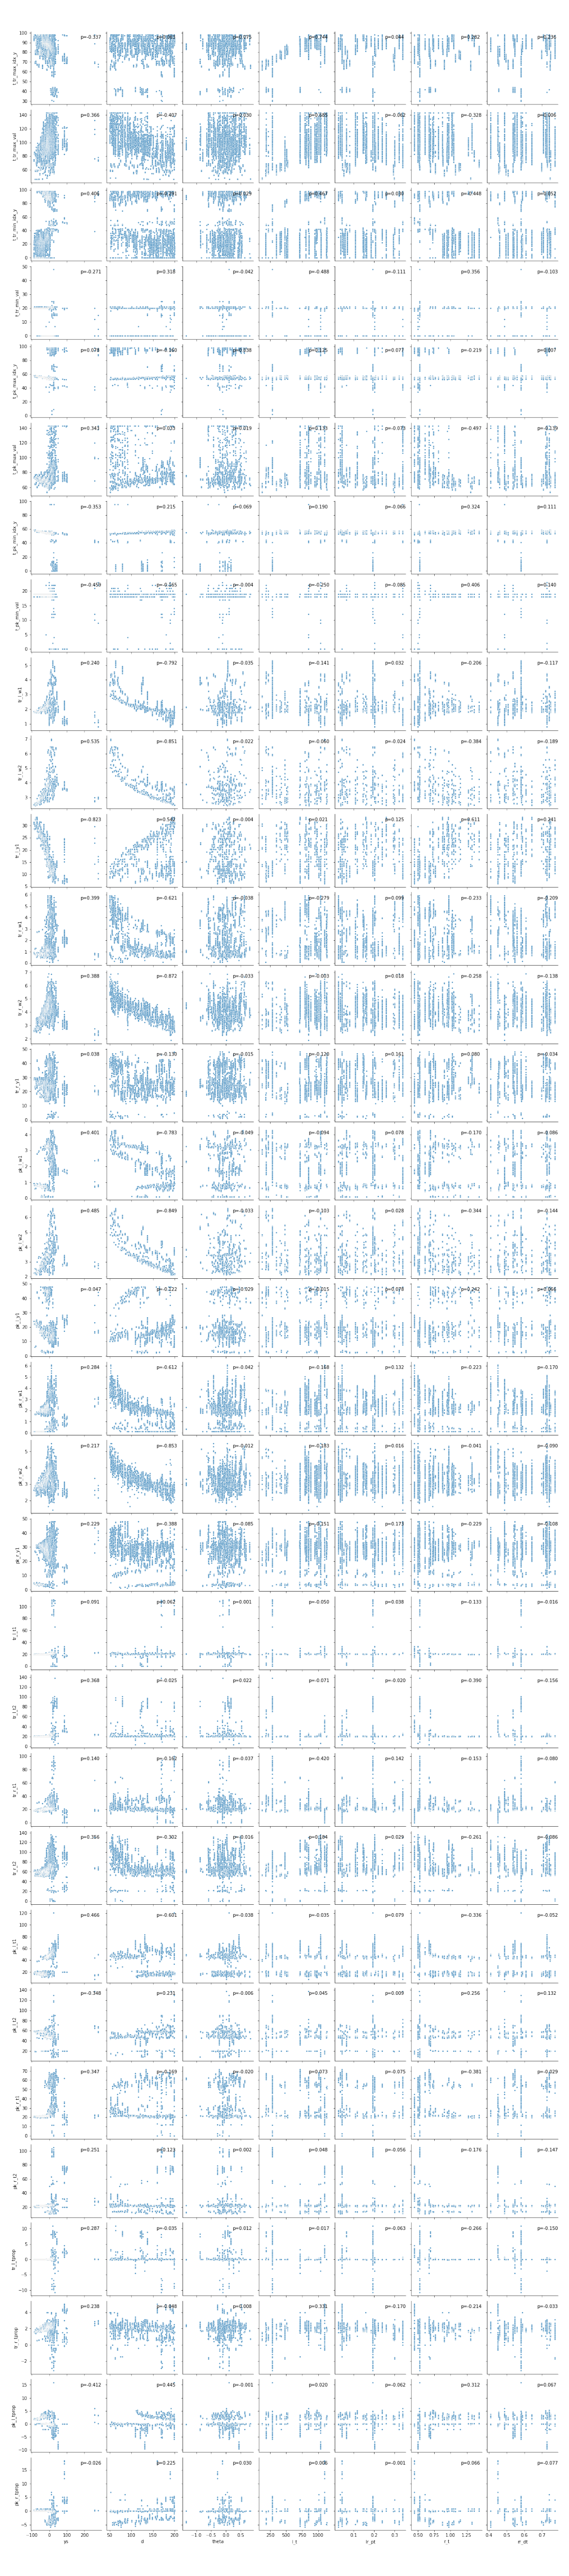

In [9]:
imgage_file = os.path.join(TRIAL_PATH, 'parameter_feature_correlation.png')
if os.path.isfile(imgage_file):
    import matplotlib.image as mpimg
    plt.figure(figsize=(16, 80))
    imgplot = plt.imshow(mpimg.imread(imgage_file), aspect='equal')
    plt.gca().axis('off')
    plt.tight_layout()
else:
    g = sns.pairplot(pd.concat((df_la, df_summ_stats), axis=1),
                     x_vars=label_list, y_vars=summ_stats_names,
                     plot_kws=dict(marker='.'))
    g.map(corr_in_plot)
    plt.savefig(imgage_file)
plt.show()

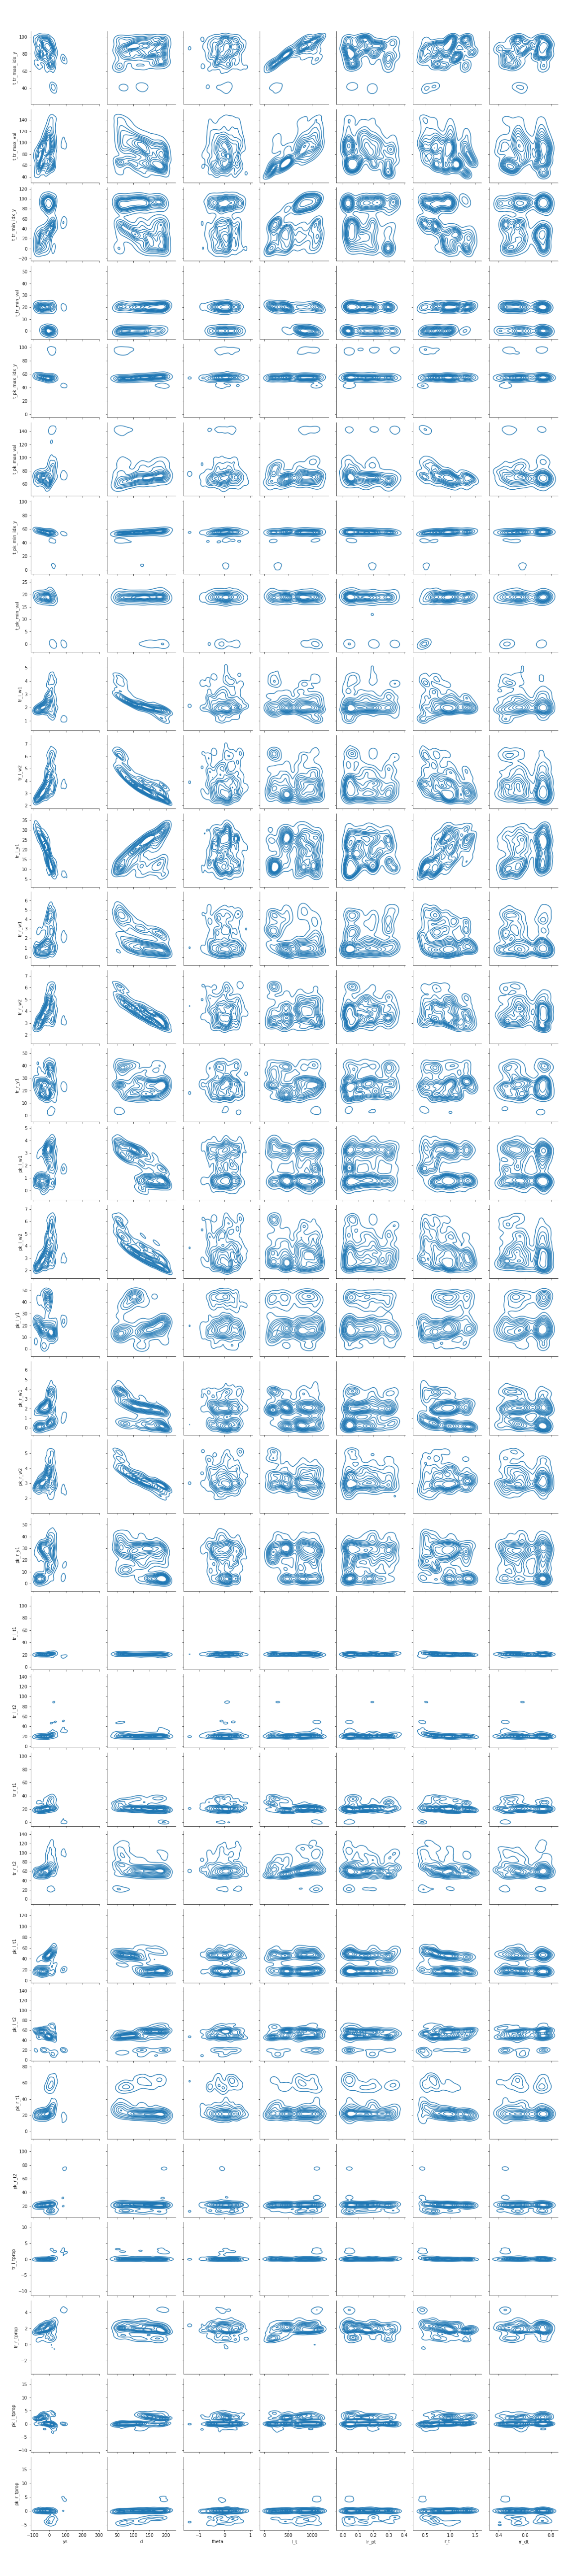

In [10]:
imgage_file = os.path.join(TRIAL_PATH, 'parameter_feature_kde.png')
if os.path.isfile(imgage_file):
    import matplotlib.image as mpimg
    plt.figure(figsize=(16, 80))
    imgplot = plt.imshow(mpimg.imread(imgage_file), aspect='equal')
    plt.gca().axis('off')
    plt.tight_layout()
else:
    g = sns.pairplot(pd.concat((df_la, df_summ_stats), axis=1),
                     x_vars=label_list, y_vars=summ_stats_names,
                     kind='kde')
    plt.savefig(imgage_file)
plt.show()

## Correlations with feature importance

In [11]:
MODEL_PATH = os.path.join(TRIAL_PATH, 'RandomForestAnalysis')
in_name = 'stats_8_24__56_68__72_84'
out_name = 'morph'

feat_all_df = pd.read_csv(os.path.join(MODEL_PATH, in_name + '-allmorph_importance.csv'), index_col=0)
feat_indiv_df = pd.read_csv(os.path.join(MODEL_PATH, in_name + '-individual_importance.csv'), header=[0, 1], index_col=0)
with open(os.path.join(MODEL_PATH, out_name + '_out.txt'), 'r') as f:
        label_list = f.read().splitlines()

with pd.option_context('display.max_rows', None, 'display.float_format', '{:.3g}'.format):
    display(feat_all_df)
    display(feat_indiv_df)

id  importance         feature
0   11       0.198  t_tr_max_idx_y
1   12       0.131    t_tr_max_val
2   73      0.0962         tr_l_t2
3   77      0.0869         pk_l_t2
4   20      0.0618    t_pk_max_val
5   14      0.0617  t_tr_min_idx_y
6   72      0.0525         tr_l_t1
7   74      0.0343         tr_r_t1
8   76      0.0266         pk_l_t1
9   23      0.0245    t_pk_min_val
10  59      0.0244         tr_r_w1
11  58       0.022         tr_l_y1
12  81      0.0178      tr_r_tprop
13  75      0.0154         tr_r_t2
14  61      0.0142         tr_r_y1
15  80      0.0134      tr_l_tprop
16  82       0.013      pk_l_tprop
17  62      0.0129         pk_l_w1
18  79      0.0106         pk_r_t2
19  78        0.01         pk_r_t1
20  66        0.01         pk_r_w2
21  60     0.00896         tr_r_w2
22  56     0.00863         tr_l_w1
23  57     0.00742         tr_l_w2
24  64     0.00739         pk_l_y1
25  63     0.00603         pk_l_w2
26  67     0.00553         pk_r_y1
27  83     0.00553      pk_r_tprop
28  65     0.00545         pk_r_w1
29  15     0.00343    t_tr_min_val
30  19     0.00291  t_pk_max_idx_y
31  22     0.00177  t_pk_min_idx_y

l_t                            lr_pt                            r_t  \
    id importance         feature    id importance         feature  id   
0   12      0.427    t_tr_max_val    74      0.103         tr_r_t1  73   
1   11       0.35  t_tr_max_idx_y    20     0.0977    t_pk_max_val  72   
2   23     0.0495    t_pk_min_val    12      0.094    t_tr_max_val  59   
3   14     0.0276  t_tr_min_idx_y    77     0.0779         pk_l_t2  74   
4   74     0.0193         tr_r_t1    14     0.0695  t_tr_min_idx_y  14   
5   73     0.0179         tr_l_t2    11     0.0605  t_tr_max_idx_y  61   
6   77     0.0167         pk_l_t2    72     0.0595         tr_l_t1  20   
7   56     0.0113         tr_l_w1    56     0.0465         tr_l_w1  76   
8   20    0.00911    t_pk_max_val    58     0.0441         tr_l_y1  80   
9   15    0.00886    t_tr_min_val    73      0.039         tr_l_t2  60   
10  75    0.00857         tr_r_t2    59     0.0346         tr_r_w1  77   
11  59    0.00529         tr_r_w1    22     0.0292  t_pk_min_idx_y  81   
12  58     0.0052         tr_l_y1    75     0.0232         tr_r_t2  11   
13  79    0.00495         pk_r_t2    81       0.02      tr_r_tprop  62   
14  64    0.00404         pk_l_y1    76     0.0196         pk_l_t1  78   
15  72    0.00379         tr_l_t1    80     0.0178      tr_l_tprop  75   
16  76    0.00378         pk_l_t1    61     0.0162         tr_r_y1  58   
17  57    0.00299         tr_l_w2    63     0.0157         pk_l_w2  12   
18  62    0.00269         pk_l_w1    64     0.0145         pk_l_y1  79   
19  82    0.00254      pk_l_tprop    82     0.0135      pk_l_tprop  56   
20  80    0.00254      tr_l_tprop    79     0.0118         pk_r_t2  63   
21  60    0.00251         tr_r_w2    62      0.011         pk_l_w1  82   
22  61    0.00248         tr_r_y1    57     0.0108         tr_l_w2  23   
23  63    0.00245         pk_l_w2    66    0.00982         pk_r_w2  67   
24  81    0.00179      tr_r_tprop    23    0.00953    t_pk_min_val  15   
25  22    0.00177  t_pk_min_idx_y    19     0.0094  t_pk_max_idx_y  65   
26  78    0.00127         pk_r_t1    78    0.00908         pk_r_t1  57   
27  67    0.00114         pk_r_y1    83    0.00893      pk_r_tprop  64   
28  19   0.000746  t_pk_max_idx_y    60     0.0086         tr_r_w2  66   
29  66   0.000663         pk_r_w2    67    0.00789         pk_r_y1  22   
30  83   0.000614      pk_r_tprop    65    0.00603         pk_r_w1  83   
31  65   0.000608         pk_r_w1    15    0.00156    t_tr_min_val  19   

                              rr_dt                             
   importance         feature    id importance         feature  
0       0.556         tr_l_t2    11       0.13  t_tr_max_idx_y  
1       0.138         tr_l_t1    12      0.121    t_tr_max_val  
2      0.0832         tr_r_w1    77      0.112         pk_l_t2  
3      0.0276         tr_r_t1    80      0.087      tr_l_tprop  
4      0.0251  t_tr_min_idx_y    76      0.077         pk_l_t1  
5      0.0222         tr_r_y1    78     0.0654         pk_r_t1  
6      0.0181    t_pk_max_val    73     0.0305         tr_l_t2  
7      0.0152         pk_l_t1    59     0.0298         tr_r_w1  
8      0.0141      tr_l_tprop    62     0.0287         pk_l_w1  
9      0.0126         tr_r_w2    74     0.0264         tr_r_t1  
10     0.0113         pk_l_t2    20     0.0256    t_pk_max_val  
11     0.0109      tr_r_tprop    82     0.0222      pk_l_tprop  
12     0.0104  t_tr_max_idx_y    14      0.022  t_tr_min_idx_y  
13    0.00709         pk_l_w1    75     0.0214         tr_r_t2  
14    0.00594         pk_r_t1    79     0.0189         pk_r_t2  
15    0.00502         tr_r_t2    58     0.0189         tr_l_y1  
16    0.00478         tr_l_y1    64     0.0157         pk_l_y1  
17    0.00422    t_tr_max_val    83     0.0157      pk_r_tprop  
18    0.00347         pk_r_t2    56     0.0151         tr_l_w1  
19    0.00304         tr_l_w1    57     0.0147         tr_l_w2  
20    0.00274         pk_l_w2    81     0.0142      tr_r

#### All morphological parameters together

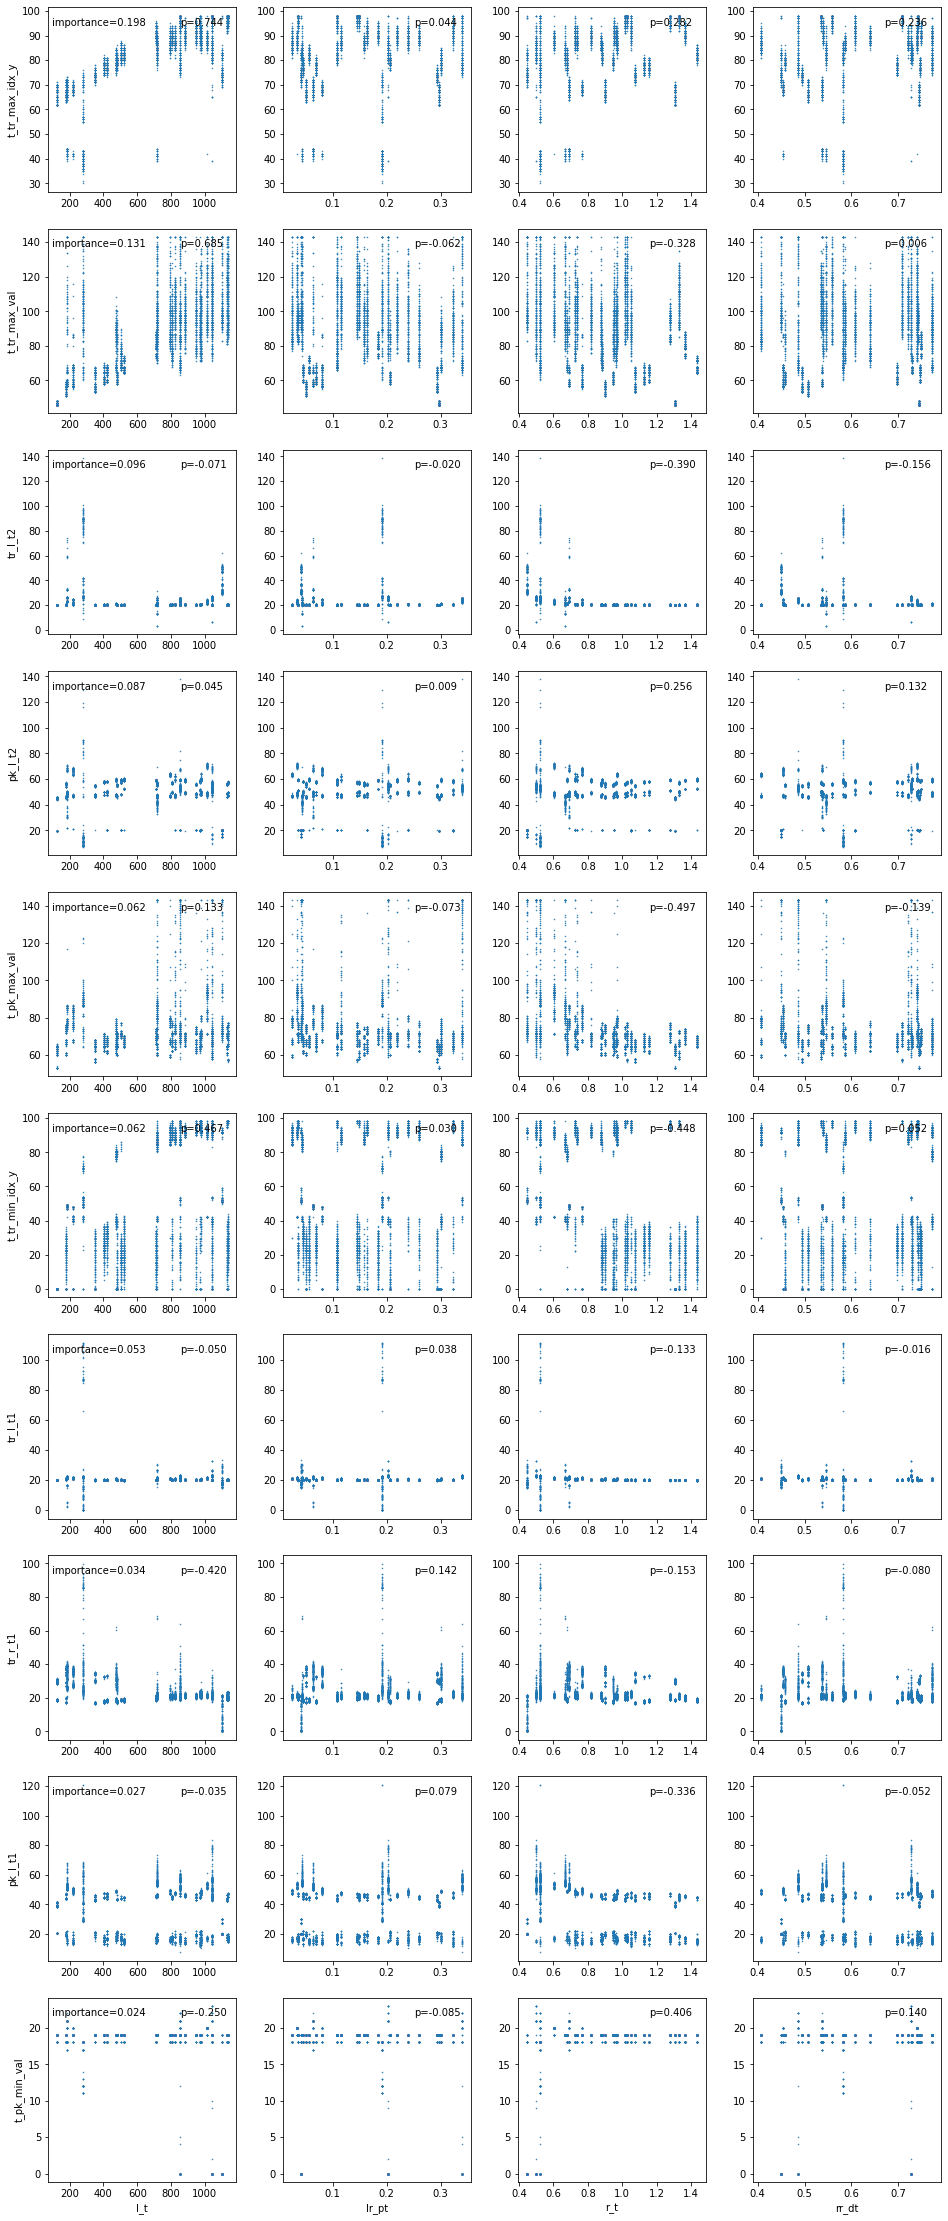

In [12]:
n_top = 10

_, axs = plt.subplots(n_top, len(label_list), figsize=(4 * len(label_list), 4 * n_top), squeeze=False)
for i in range(n_top):
    feature = feat_all_df.loc[i, 'feature']
    y = df_summ_stats[feature]
    for j, L in enumerate(label_list):
        x = df_la[L]
        ax = axs[i, j]
        ax.plot(x, y, '.', markersize=1)
        _ = corr_in_plot(x, y, xy=(.7, .9), ax=ax)
    importance = feat_all_df.loc[i, 'importance']
    ax = axs[i, 0]
    ax.annotate(f'importance={importance:.3f}', xy=(.02, .9), xycoords=ax.transAxes)
    ax.set_ylabel(feature)
for ax, L in zip(axs[-1], label_list):
    ax.set_xlabel(L)
aling_axes_limits(axs, include_diag=True)
plt.subplots_adjust(wspace=0.25)
plt.show()

#### Individual morphological parameters

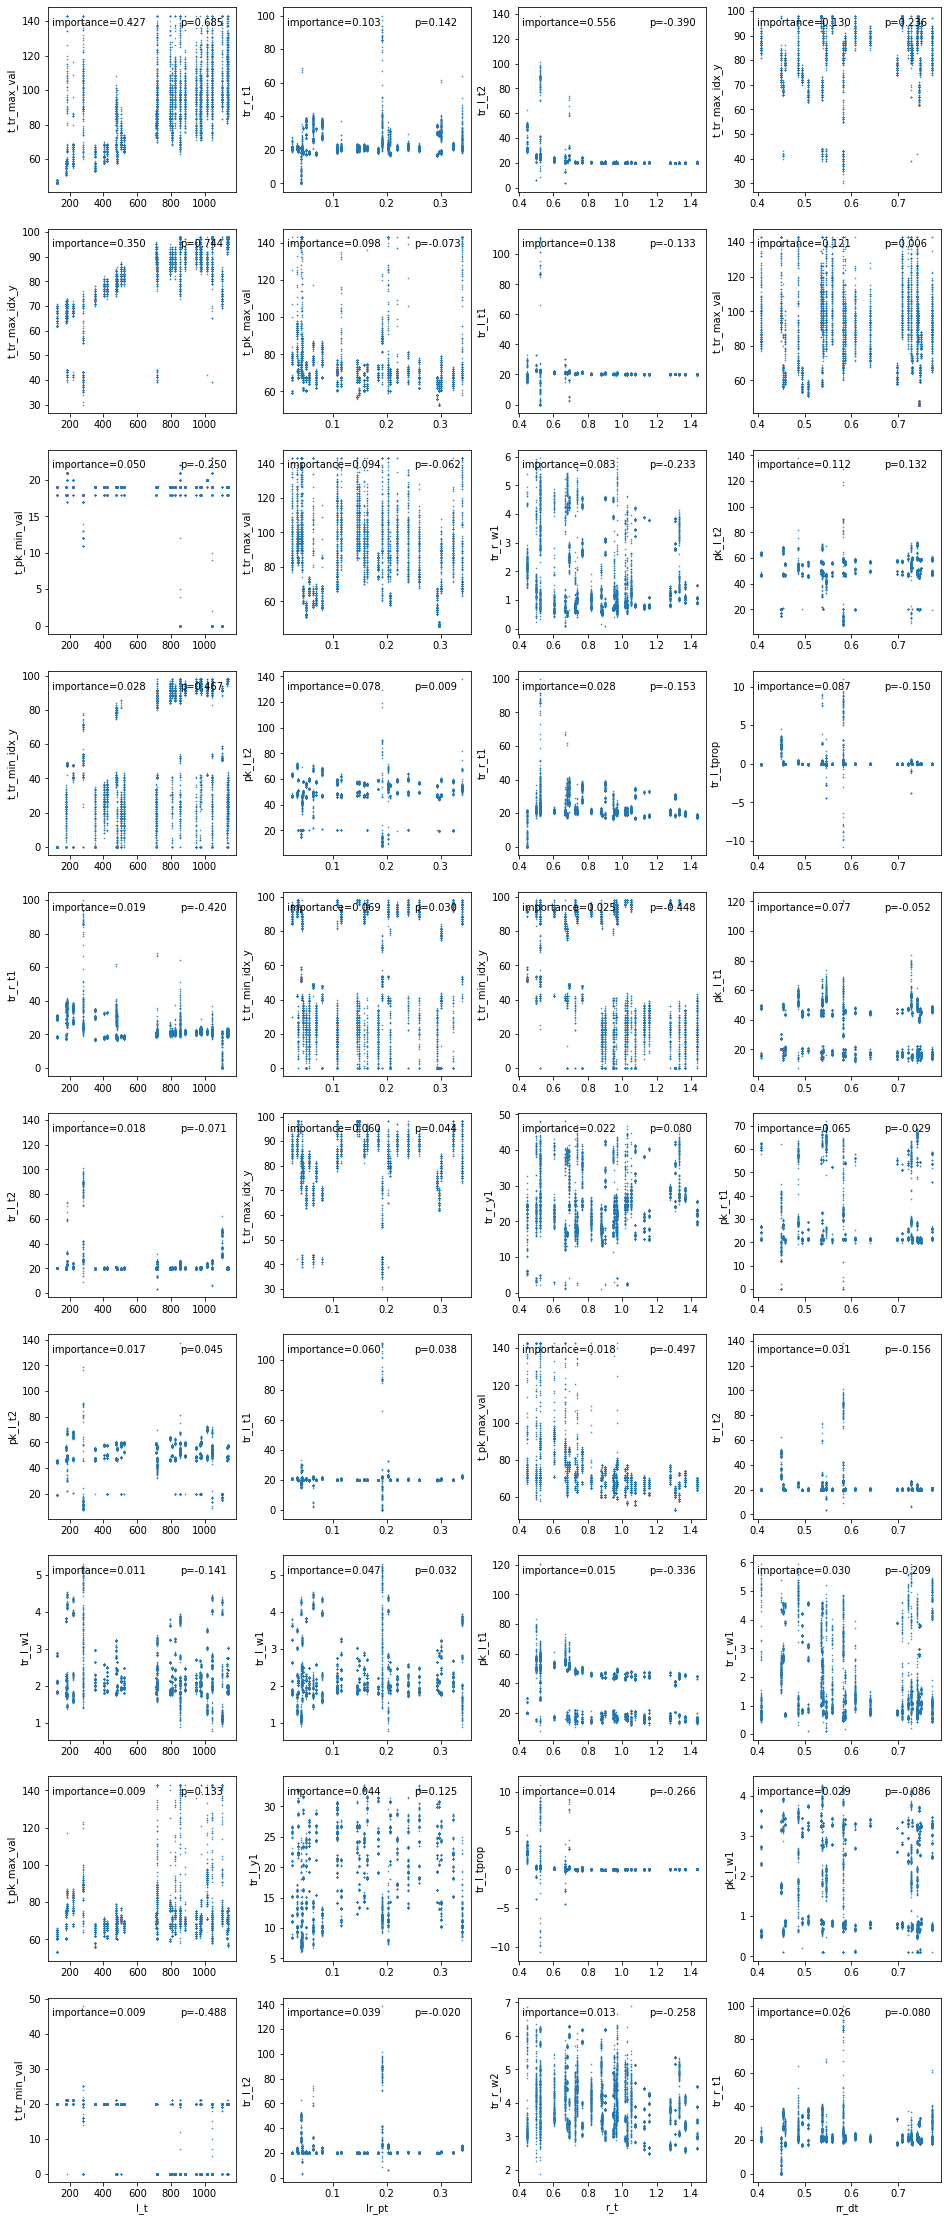

In [13]:
_, axs = plt.subplots(n_top, len(label_list), figsize=(4 * len(label_list), 4 * n_top), squeeze=False)
for i in range(n_top):
    for j, L in enumerate(label_list):
        feature = feat_indiv_df.loc[i, (L, 'feature')]
        y = df_summ_stats[feature]
        x = df_la[L]
        ax = axs[i, j]
        ax.plot(x, y, '.', markersize=1)
        _ = corr_in_plot(x, y, xy=(.7, .9), ax=ax)
        importance = feat_indiv_df.loc[i, (L, 'importance')]
        ax.annotate(f'importance={importance:.3f}', xy=(.02, .9), xycoords=ax.transAxes)
        ax.set_ylabel(feature)
for ax, L in zip(axs[-1], label_list):
    ax.set_xlabel(L)
aling_axes_limits(axs, axis='x', include_diag=True)
plt.subplots_adjust(wspace=0.25)
plt.show()